# Minimal CASteer Tutorial
Demonstrates activation steering with compositional attributes using Stable Diffusion XL

## Setup
Load the pipeline and helper functions.

In [11]:
import os
import re
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torch.nn.functional as F

In [ ]:
!git clone https://github.com/sidhantls/minimal-casteer
%cd minimal-casteer
! git pull origin main

Cloning into 'minimal-casteer'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 68 (delta 32), reused 49 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 198.01 KiB | 28.29 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/minimal-casteer
From https://github.com/sidhantls/minimal-casteer
 * branch            main       -> FETCH_HEAD
Already up to date.


In [ ]:
from diffusers import StableDiffusionXLPipeline
import torch
import steering
import prompt_catalog

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    generator=torch.Generator().manual_seed(0),
)
pipe.to("cuda")
pipe.set_progress_bar_config(disable=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'generator': <torch._C.Generator object at 0x7c79d0a7cad0>} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Hyperparameters
Basic settings for steering.

In [5]:
STEER_TYPE = "default"
INF_STEPS = 20
GUIDE_SCALE = 5.0
PROMPT_THEME = "anime" # anime or metal


In [6]:
# from google.colab import drive
# drive.mount('/content/drive/collab_data')

%md
## Build and apply steering vectors

To guide a model’s generation toward or away from a target attribute, we will construct **steering vectors**. The process involves four steps:

1. **Create prompt pairs**  
   We start by defining two sets of prompts:  
   - **Positive prompts** that contain the target attribute (e.g., “box turtle, anime style").  
   - **Baseline prompts** that are matched but neutral (e.g., "box turtle").  
   These pairs allow us to isolate the effect of the attribute by controlling for context.

2. **Cache conditional activations**  
   For each prompt, we record the model’s hidden activations at a chosen layer. This caching step is crucial because we want to compare how the internal representations differ between positive and baseline prompts. Efficient caching avoids recomputation during training or experimentation.

3. **Calculate steering vectors**  
   The steering vector is defined as the difference between the average hidden activations of the positive and baseline prompts:  
$$
v = \frac{1}{N} \sum_{i=1}^N h(x_i^{+}) - \frac{1}{M} \sum_{j=1}^M h(x_j^{-})
$$


   where \(h(x)\) is the activation of prompt \(x\) at the chosen layer, \(x_i^{+}\) are positive prompts, and \(x_j^{-}\) are baseline prompts.  
   This vector \(v\) represents the “direction” in activation space corresponding to the target attribute ([Meng et al., 2025](https://arxiv.org/abs/2503.09630)).

4. **Register steering vectors**  
   Finally, we apply the steering vector during generation. At each forward pass, we adjust the hidden activations by adding or subtracting a scaled version of \(v\):  

$$
   h'(x) = h(x) + \alpha v
$$


   where $\alpha$ controls the strength of steering. Positive $\alpha$ amplifies the attribute, while negative $\alpha$ suppresses it.


### Create prompt pairs
Each pair contains a steered prompt and a neutral prompt. Feel free to swap in your own themes.


In [7]:
if PROMPT_THEME == "anime":
    prompts = prompt_catalog.ANIME_PROMPT[:20]
elif PROMPT_THEME == "metal":
    prompts = prompt_catalog.METALLIC_SCULPTURE_SET[:20]
else:
    raise NotImplementedError(f"Prompt theme {PROMPT_THEME} not implemented")

print('Example of the prompts:\n')
for p in prompts[:5]:
  print(p)


Example of the prompts:

('tench, anime style', 'tench')
('goldfish, anime style', 'goldfish')
('great white shark, anime style', 'great white shark')
('tiger shark, anime style', 'tiger shark')
('hammerhead, anime style', 'hammerhead')


### Attach steer hooks
`add_steer_hooks` registers forward hooks on attention layers to cache activations.


In [8]:
steer_hooks = steering.add_steer_hooks(
    pipe,
    steer_type=STEER_TYPE,
    save_every=1,
)


[hooks] Added 70 cross-attn hooks


### Build steering vector
Run the prompt pairs through the model to compute the conditional activation differences.


In [9]:
final_vecs = steering.build_final_steering_vectors(
    pipe,
    steer_hooks,
    prompts,
    num_inference_steps=INF_STEPS,
    guidance_scale=GUIDE_SCALE,
)
print(final_vecs[0].shape)


  0%|          | 0/20 [00:00<?, ?it/s]

[vectors] Built 70 steering vectors; each like (40, 1, 640)
torch.Size([40, 1, 640])


### Composte New Attribute

In [12]:
## Calculate Steering Vectors 2
prompts2 = prompt_catalog.HAPPY_EXPRESSION_SET[:20] # or insert your own second attribute
final_vecs2 = steering.build_final_steering_vectors(
    pipe,
    steer_hooks,
    prompts2,
    num_inference_steps=INF_STEPS,
    guidance_scale=GUIDE_SCALE
)

## Compose Steering Vectors
merge_alpha = 0.5 # weight on first steering vector
for i in range(len(final_vecs)):
    merged = merge_alpha * final_vecs[i] + (1 - merge_alpha) * final_vecs2[i]
    merged = F.normalize(merged, p=2, dim=-1)
    final_vecs[i] = merged
print("Merged and renormalized expression vectors")

Merged and renormalized expression vectors


### Register steering vector
Attach the computed vectors so they influence future generations.


In [14]:
steering.add_final_steer_vectors(steer_hooks, final_vecs)


[hooks] Attached 70 steering vectors


## Generate images
Apply the steering vectors to new prompts and compare results.

In [15]:
TEST_PROMPTS = [
    "Studio-lit Batman logo on a plain background, 4K detail.",
    "Cinematic close-up of Batman's face, dramatic shadows across the cowl, ultra-detailed, 4K.",
    "Close-up of a labrador sitting.",
    "Portrait of an Apple.",
    "Close-up of a amicable robot face, made of plastic, with a neural expression.",
    "Portrait of a carved pumpkin jack-o’-lantern with a neural expression, dramatic lighting.",

    "Cinematic portrait of an astronaut with reflective visor, stars and Earth visible, ultra-detailed.",
    "Photorealistic close-up of sushi rolls on a wooden plate with soy sauce and wasabi.",
    "Minimalist black-and-white sketch of a cat stretching.",
]


STEER_SCALE_LIST = [0.0, 2.0, 5.0, 10.0]
steering.run_grid_experiment(
    pipe,
    steer_hooks,
    TEST_PROMPTS,
    num_inference_steps=INF_STEPS,
    steer_type=STEER_TYPE,
    gscale_list=[GUIDE_SCALE],
    steer_scale_list=STEER_SCALE_LIST,
    out_root=f"{PROMPT_THEME}_experiments",
)


[grid] Saved 9 images -> steps=20, guide=5.0, steer=0.0, type=default
[grid] Saved 9 images -> steps=20, guide=5.0, steer=2.0, type=default
[grid] Saved 9 images -> steps=20, guide=5.0, steer=5.0, type=default
[grid] Saved 9 images -> steps=20, guide=5.0, steer=10.0, type=default


## Plot Images

### Utils

In [16]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def extract_steer_value(folder_name: str) -> float:
    """Extracts the steer value from a folder name like steps=20_guide=5.0_steer=0.5_type=default."""
    match = re.search(r"steer=([0-9]*\.?[0-9]+)", folder_name)
    return float(match.group(1)) if match else float("inf")

def plot_all_param_images(base_folder: str, save_dir: str = "plots_output"):
    """
    For each unique filename across param folders, plot horizontally across all
    steer values and save the plot.

    Args:
        base_folder (str): Path to the experiments folder (e.g. 'metal_experiments').
        save_dir (str): Folder where plots will be saved.

    Returns:
        List[str]: Filenames of saved plots.
    """
    os.makedirs(save_dir, exist_ok=True)

    # list all param subfolders
    param_folders = [os.path.join(base_folder, f) for f in os.listdir(base_folder)
                     if os.path.isdir(os.path.join(base_folder, f))]

    if not param_folders:
        raise ValueError("No param folders found in base folder.")

    # sort by steer value
    param_folders.sort(key=lambda x: extract_steer_value(os.path.basename(x)))

    # collect all unique filenames from the first folder
    sample_files = [f for f in os.listdir(param_folders[0]) if f.lower().endswith((".jpg", ".png"))]
    if not sample_files:
        raise ValueError("No images found in param folders.")

    saved_plots = []

    # loop through all unique filenames
    for chosen_file in sample_files:
        images = []
        labels = []
        for pf in param_folders:
            img_path = os.path.join(pf, chosen_file)
            if os.path.exists(img_path):
                images.append(mpimg.imread(img_path))
                labels.append(os.path.basename(pf))

        if not images:
            continue

        # plot horizontally
        n = len(images)
        plt.figure(figsize=(4*n, 4))
        for i, (img, label) in enumerate(zip(images, labels)):
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.axis("off")
            steer_val = extract_steer_value(label)
            plt.title(f"$\\alpha$={steer_val}", fontsize=10)  # alpha symbol

        # add main title = filename
        # plt.suptitle(chosen_file, fontsize=12, y=1.02)

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # prevent clipping

        # save figure
        save_filename = f"{os.path.splitext(chosen_file)[0]}_comparison.png"
        save_path = os.path.join(save_dir, save_filename)
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()

        saved_plots.append(save_filename)

    print(f"All plots saved in: {os.path.abspath(save_dir)}")
    return saved_plots

def list_saved_plots(save_dir: str = "plots_output"):
    """List all saved plots in the output directory."""
    if not os.path.exists(save_dir):
        raise FileNotFoundError(f"{save_dir} not found.")
    plots = [f for f in os.listdir(save_dir) if f.endswith("_comparison.png")]
    print("Available plots:", plots)
    return plots

def load_saved_plot(filename: str, save_dir: str = "plots_output"):
    """
    Load and display a saved plot by filename.

    Args:
        filename (str): Filename of saved plot (e.g. '00001_comparison.png').
        save_dir (str): Directory where plots were saved.
    """
    file_path = os.path.join(save_dir, filename)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found.")

    img = mpimg.imread(file_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


### Plot figures

In [17]:
# Example usage:
folder = f"{PROMPT_THEME}_experiments"
save_dir = os.path.join(folder, "plots_output")

# Generate and save all comparison plots
saved = plot_all_param_images(folder, save_dir=save_dir)

All plots saved in: /content/minimal-casteer/anime_experiments/plots_output


### Load plot

Available plots: ['gen_04_comparison.png', 'gen_03_comparison.png', 'gen_08_comparison.png', 'gen_01_comparison.png', 'gen_07_comparison.png', 'gen_02_comparison.png', 'gen_06_comparison.png', 'gen_09_comparison.png', 'gen_05_comparison.png']
gen_09_comparison.png


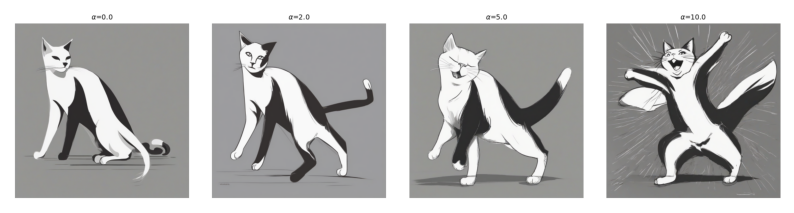

In [18]:
# List what was saved
available = list_saved_plots(save_dir)
path = random.sample(available, 1)[0]

print(path)

# Load one saved plot
if available:
    load_saved_plot(path, save_dir=save_dir)

In [19]:
!tar -czvf {PROMPT_THEME}_experiments.tar.gz {PROMPT_THEME}_experiments/plots_output


anime_experiments/plots_output/
anime_experiments/plots_output/gen_04_comparison.png
anime_experiments/plots_output/gen_03_comparison.png
anime_experiments/plots_output/gen_08_comparison.png
anime_experiments/plots_output/gen_01_comparison.png
anime_experiments/plots_output/gen_07_comparison.png
anime_experiments/plots_output/gen_02_comparison.png
anime_experiments/plots_output/gen_06_comparison.png
anime_experiments/plots_output/gen_09_comparison.png
anime_experiments/plots_output/gen_05_comparison.png
